# Machine Learning Model Implementations
This file includes machine learning model implementations and optimization steps.
The models used in order is as follows:
1. KNN classifier
2. ...


### Import Packages and Load Dataset

Labels come from 2 different PSG systems: Remlogic and Somnomedics. Sleep stage labels are as follows:

0 = Awake = SLEEP-S0 \
1 = REM   = SLEEP-REM \
2 = Light = SLEEP-S1 and  SLEEP-S2 \
3 = Deep  = SLEEP-S3 

EMFIT is the piezoelectric mat and Somnofy is the radar.

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB

import numpy as np
from helpers import *
from plot import *

In [2]:
subjectID = PARTICIPANT_IDS[3]
sleep_stages, nan_counts = impute_data(subjectID)
print(nan_counts)

(0, 0, 0)


In [3]:
labels = sleep_stages["sleep_stage_num_psg"]
features = sleep_stages.drop(columns="sleep_stage_num_psg")
size = sleep_stages.shape[0]
divide_ind = int(size*.7)

In [4]:
print("Radar: ", balanced_accuracy_score( labels[:divide_ind], sleep_stages["sleep_stage_num_somnofy"][:divide_ind]))
print("Mat: ", balanced_accuracy_score( labels[:divide_ind], sleep_stages["sleep_stage_num_emfit"][:divide_ind]))

Radar:  0.3952575396197906
Mat:  0.32039831725701035


<AxesSubplot:xlabel='timestamp_local'>

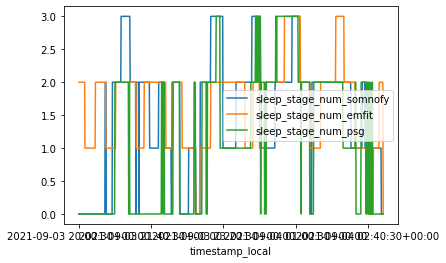

In [5]:
sleep_stages.plot()

In [6]:
x_tr, y_tr = features[:divide_ind], labels[:divide_ind]
x_te, y_te = features[divide_ind:], labels[divide_ind:]

### KNN Classifier

In [7]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(x_tr, y_tr)

KNeighborsClassifier(n_neighbors=7)

In [8]:
preds = knn_classifier.predict(x_te)

0.6155860071301248
[[64  0  2  0]
 [12  0 19  3]
 [43  0 67 26]
 [ 0  0  0 17]]


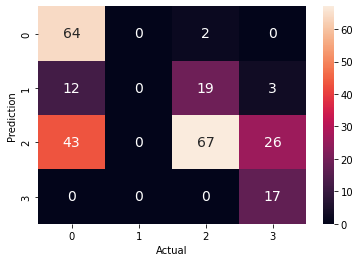

In [9]:
# Accuracy score 
print(balanced_accuracy_score( y_te, preds))

# Confusion Matrix and Classification Report 
plot_conf_matrix(preds, y_te)
# print(classification_report( y_te, preds))

### Naive Bayes 

In [10]:
cnb_classifier = CategoricalNB()
cnb_classifier.fit(x_tr, y_tr)

CategoricalNB()

In [11]:
preds = cnb_classifier.predict(x_te)

0.5928587344028521
[[58  0  8  0]
 [ 0  0 31  3]
 [43  0 67 26]
 [ 0  0  0 17]]


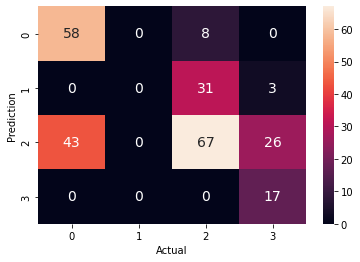

In [12]:
# Accuracy score 
print(balanced_accuracy_score( y_te, preds))

# Confusion Matrix and Classification Report 
plot_conf_matrix(preds, y_te)
# print(classification_report( y_te, preds))